# Testing Stuff

In [1]:
import os
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt





from src.constants import *
from src.utils.csv_utils import read_csv_to_dataframe
from src.services.meal_filter import *
from src.openai_client import *
from src.utils.date_utils import *
from src.services.meal_grouping import *
from src.utils.pandas_utils import *

## Reading the CSV file
The .csv file will be read into a new 'df'

In [2]:
csv_file_path = os.path.join('data', 'cohort_2a00ae12-11c3-4eb0-a0d8-f79ca8944ee6_annotation_items_20240314T125928Z.csv')

meals_df = read_csv_to_dataframe(csv_file_path)
meals_df.shape

(1198, 249)

In [3]:
def inspect_dataframe(df):
    """
    Inspects a DataFrame by printing its shape and displaying its head.

    Parameters:
    - df: The DataFrame to inspect.
    """
    print(f"Shape of DataFrame: {df.shape}")
    df.head(5)

## Retrieving data for the person that logged most food
The dataframe will be filtered and we will get only the rows corresponding to the user that logged food most times

In [4]:
participation_key_counts = meals_df['participation_key'].value_counts()
most_common_participation_key = participation_key_counts.idxmax()
selected_rows = meals_df[meals_df['participation_key'] == most_common_participation_key]

most_meal_logs_df = selected_rows.copy()
most_meal_logs_df.head(5)
print(f"The new dataframe has this shape: {most_meal_logs_df.shape}")

The new dataframe has this shape: (798, 249)


Create another column for Zurich time zone

In [5]:
# Assuming 'df' is your DataFrame and 'consumed_at' contains UTC times
most_meal_logs_df['consumed_at'] = pd.to_datetime(most_meal_logs_df['consumed_at'])

# Directly convert to 'Europe/Zurich' timezone, assuming 'consumed_at' is already timezone-aware
most_meal_logs_df['local_time'] = most_meal_logs_df['consumed_at'].dt.tz_convert('Europe/Zurich')

### Meal items grouped together
Here we are grouping all the foods for a given *'intake_id'* \
\
*meals_df* contains each unique intake_id along with a concatenated string of food_names for that meal

In [6]:
meals_df = meals_df.groupby('intake_id')['food_name'].apply(lambda x: ', '.join(x.dropna())).reset_index()
meals_df.head(5)

,intake_id,food_name
0,010a4910-36ae-407e-866e-e6d7001fd588,"Drinking water (average Switzerland), Apple, f..."
1,01d3940c-a805-4244-a81f-4c2df1a0a6dd,"Onion, raw, Parsley, fresh, Chips, french frie..."
2,02189a9e-e99e-4574-bd40-5c8fe31c4727,Naan (Indian bread)
3,02d6be49-1fd7-4e6b-822a-ad0d1e2c0dfd,"Butterhead lettuce, raw"
4,02f2c205-6d4b-48ba-9784-b9e0a61e4046,"Broccoli, raw, Chicken egg, whole, hard boiled..."


## Meal Filtering options
**To be noted:** we are doing all the filtering processes on a DataFrame that contains only the data of the person that logged food the most

#### Last Meal
Return the last meal

In [7]:
abc = filter_last_meal(most_meal_logs_df)
abc.shape

(119, 250)

#### Given Date Meals

By giving a date, we will have a new *df* with all the food logs, and their related macronutrients

In [8]:
given_date_meals_df = filter_meals_by_date(most_meal_logs_df, '2023-12-13')

print_df_shape(given_date_meals_df)
given_date_meals_df.head(5)

The dataframe has this shape: (12, 11)


,consumed_at,food_name,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,sodium,intake_id
0,2023-12-13 11:04:19.401000+00:00,NaN,166.25,NaN,6.13,22.75,5.25,3.15,NaN,NaN,16224147-5b65-456a-8fc2-22a65ccd97a8
1,2023-12-13 08:03:22.290000+00:00,"Coffee, black, no sugar added",2.00,99.60,0.10,0.30,0.00,0.00,0.1,1.30,cdeb2e8b-5db9-4be5-8f63-42212d7fdc4f
2,2023-12-13 09:06:45.225000+00:00,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,1a309f09-46f5-4ea5-aaf6-56c0dd87cab5
3,2023-12-13 18:27:04.751000+00:00,"Molluscs, blue mussel, raw",17.00,16.42,2.34,0.68,0.54,0.10,0.0,58.00,bbdff668-a8b6-4683-bd65-16c47caa36ee
4,2023-12-13 18:27:04.751000+00:00,"Oil, olive",161.80,0.00,0.00,0.00,17.98,2.34,0.0,0.18,bbdff668-a8b6-4683-bd65-16c47caa36ee


#### Date Range Meals
This type of query would be ideal to query information, about weekend, week, month, etc.

In [9]:
date_range_meals_df = filter_meals_by_date_range(most_meal_logs_df, '2023-12-13', '2023-12-19')

print(f"The dataframe has this shape: {date_range_meals_df.shape}")
date_range_meals_df.head(5)

The dataframe has this shape: (39, 11)


,consumed_at,food_name,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,sodium,intake_id
0,2023-12-13 08:03:22.290000+00:00,"Coffee, black, no sugar added",2.0,99.60,0.10,0.30,0.00,0.00,0.10,1.3,cdeb2e8b-5db9-4be5-8f63-42212d7fdc4f
1,2023-12-13 09:06:45.225000+00:00,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,0.0,1a309f09-46f5-4ea5-aaf6-56c0dd87cab5
2,2023-12-13 11:03:59.411000+00:00,"Carrot, steamed, without addition of salt",12.3,26.40,0.27,2.19,0.09,0.00,0.87,7.5,c740f8c4-e02c-4376-8d73-20f39f42a4dd
3,2023-12-13 11:03:59.411000+00:00,"Rice parboiled, cooked in salted water (uniodi...",144.0,84.24,2.88,32.04,0.36,0.12,0.48,648.0,c740f8c4-e02c-4376-8d73-20f39f42a4dd
4,2023-12-13 11:03:59.411000+00:00,"Shrimp, boiled",27.6,53.52,5.40,0.78,0.30,0.06,0.00,102.0,c740f8c4-e02c-4376-8d73-20f39f42a4dd


##### Last Week

In [10]:
start_date, end_date = get_last_week_dates()
print(start_date, end_date)

last_week_meals_df = filter_meals_by_date_range(most_meal_logs_df, start_date, end_date)

print(f"The dataframe has this shape: {last_week_meals_df.shape}")
last_week_meals_df.head(5)

2024-05-06 2024-05-12
The dataframe has this shape: (0, 11)


,consumed_at,food_name,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,sodium,intake_id


##### Last Month

In [11]:
start_date, end_date = get_last_month_dates()
print(start_date, end_date)

last_month_meals = filter_meals_by_date_range(most_meal_logs_df, start_date, end_date)

print(f"The dataframe has this shape: {last_month_meals.shape}")
last_month_meals.head(5)

2024-04-01 2024-04-30
The dataframe has this shape: (0, 11)


,consumed_at,food_name,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,sodium,intake_id


## Meal Grouping options
This section will be useful to understand how we can group nutrients for each meal.

### Grouping by *'intake_id'*

In [12]:
macro_nutri_grouped_df = group_and_aggregate_nutrients(last_week_meals_df)

macro_nutri_grouped_df.head(5)

,intake_id,food_name,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,sodium


### Grouping by date

In [13]:
macro_nutri_date_group_df = group_by_date_and_aggregate_nutrients(last_month_meals)

macro_nutri_date_group_df.head(5)

,date,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber


## Identifying Forgetful Moments

### Grouping the dataset
Firstly, the rows of the dataset are first grouped by *'intake_id'*.\
Secondly, the rows will be again grouped but this time by *'consumed_at'* whenever they have an overlap of **10 minutes** or less.

In [14]:
df_most_meal_logs_grouped = group_by_intakeid(most_meal_logs_df)
df_most_meal_logs_grouped = df_most_meal_logs_grouped.sort_values(by='consumed_at')
df_most_meal_logs_grouped_no_timegap = df_most_meal_logs_grouped.copy()

# Calculate the time gap between consecutive logs
df_most_meal_logs_grouped['time_gap'] = df_most_meal_logs_grouped['consumed_at'].diff()

print_df_shape(df_most_meal_logs_grouped)
df_most_meal_logs_grouped.head(10)

The dataframe has this shape: (195, 12)


,intake_id,consumed_at,local_time,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,food_name,time_gap
129,a75dd21c-0e1b-465c-a700-16ef87057ddc,2023-12-12 16:10:27.257000+00:00,2023-12-12 17:10:27.257000+01:00,195.80,166.76,2.42,43.34,0.22,0.00,5.94,"Banana, raw",NaT
161,cdeb2e8b-5db9-4be5-8f63-42212d7fdc4f,2023-12-13 08:03:22.290000+00:00,2023-12-13 09:03:22.290000+01:00,2.00,99.60,0.10,0.30,0.00,0.00,0.10,"Coffee, black, no sugar added",0 days 15:52:55.033000
31,1a309f09-46f5-4ea5-aaf6-56c0dd87cab5,2023-12-13 09:06:45.225000+00:00,2023-12-13 10:06:45.225000+01:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0 days 01:03:22.935000
157,c740f8c4-e02c-4376-8d73-20f39f42a4dd,2023-12-13 11:03:59.411000+00:00,2023-12-13 12:03:59.411000+01:00,355.90,375.86,15.00,49.21,10.55,3.12,6.35,"Carrot, steamed, without addition of salt, Ric...",0 days 01:57:14.186000
89,6d981972-1f68-4136-b583-57bb01808466,2023-12-13 11:03:59.434000+00:00,2023-12-13 12:03:59.434000+01:00,0.00,200.00,0.00,0.00,0.00,0.00,0.00,Drinking water (average Switzerland),0 days 00:00:00.023000
26,16224147-5b65-456a-8fc2-22a65ccd97a8,2023-12-13 11:04:19.401000+00:00,2023-12-13 12:04:19.401000+01:00,166.25,0.00,6.13,22.75,5.25,3.15,0.00,nan,0 days 00:00:19.967000
146,bbdff668-a8b6-4683-bd65-16c47caa36ee,2023-12-13 18:27:04.751000+00:00,2023-12-13 19:27:04.751000+01:00,508.80,130.42,13.94,66.28,19.72,2.64,4.80,"Molluscs, blue mussel, raw, Oil, olive, Pasta ...",0 days 07:22:45.350000
106,8829b06a-bc7b-4c1f-a9fb-407e6a89a3e3,2023-12-14 11:24:31.643000+00:00,2023-12-14 12:24:31.643000+01:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0 days 16:57:26.892000
115,9379729c-692e-414c-af30-339b8af880b7,2023-12-14 11:31:39.650000+00:00,2023-12-14 12:31:39.650000+01:00,544.50,211.02,29.75,52.37,23.38,7.47,6.43,"Rice parboiled, cooked in salted water (uniodi...",0 days 00:07:08.007000
76,5a1bcc16-a6bc-4381-840c-25b2db229207,2023-12-14 12:02:30.954000+00:00,2023-12-14 13:02:30.954000+01:00,401.60,97.52,26.15,12.78,26.78,17.80,2.01,"nan, Coco cream, Tomato sauce",0 days 00:30:51.304000


In [15]:
# Grouping all the rows that share a 10 minutes time window
df_most_meal_logs_grouped = tmp_aggregate_by_time_window(df_most_meal_logs_grouped, "10min")
df_most_meal_logs_grouped_no_timegap = aggregate_by_time_window(df_most_meal_logs_grouped_no_timegap, "10min")

print_df_shape(df_most_meal_logs_grouped_no_timegap)
df_most_meal_logs_grouped_no_timegap.head(10)

The dataframe has this shape: (80, 9)


,local_time,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,food_name
0,2023-12-12 17:10:27.257000+01:00,195.80,166.76,2.42,43.34,0.22,0.00,5.94,"Banana, raw"
1,2023-12-13 09:03:22.290000+01:00,2.00,99.60,0.10,0.30,0.00,0.00,0.10,"Coffee, black, no sugar added"
2,2023-12-13 10:06:45.225000+01:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
3,2023-12-13 12:03:59.411000+01:00,522.15,575.86,21.13,71.96,15.80,6.27,6.35,"Carrot, steamed, without addition of salt, Ric..."
4,2023-12-13 19:27:04.751000+01:00,508.80,130.42,13.94,66.28,19.72,2.64,4.80,"Molluscs, blue mussel, raw, Oil, olive, Pasta ..."
5,2023-12-14 12:24:31.643000+01:00,544.50,211.02,29.75,52.37,23.38,7.47,6.43,"nan, Rice parboiled, cooked in salted water (u..."
6,2023-12-14 13:02:30.954000+01:00,1456.70,515.03,73.82,157.13,56.09,31.59,16.33,"nan, Coco cream, Tomato sauce, Chicken curry (..."
7,2023-12-14 13:32:29.330000+01:00,90.00,135.30,0.88,18.82,0.48,0.06,3.26,"Fruit, (average), raw, Cream desserts, pudding..."
8,2023-12-18 17:05:56.155000+01:00,0.16,500.00,0.02,0.02,0.00,0.00,0.00,"Drinking water (average Switzerland), nan"
9,2023-12-19 19:52:54.557000+01:00,470.40,235.81,20.47,3.53,32.61,11.99,2.52,"Leek, raw, Bernese tongue sausage, Drinking wa..."


In [16]:
# Sort the DataFrame by 'consumed_at'
df_most_meal_logs_grouped = df_most_meal_logs_grouped.sort_values(by='local_time').reset_index(drop=True)

### Time Gap Analysis
This is the first type of analysis we will be conducting on the database.\
The main target of this analysis is to identify which are the moments where the user is less consistent in logging food.

#### Time Gaps Summary

In [17]:
df_most_meal_logs_grouped.head(3)

,local_time,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,food_name,time_gap
0,2023-12-12 17:10:27.257000+01:00,195.8,166.76,2.42,43.34,0.22,0.0,5.94,"Banana, raw",NaT
1,2023-12-13 09:03:22.290000+01:00,2.0,99.60,0.10,0.30,0.00,0.0,0.10,"Coffee, black, no sugar added",0 days 15:52:55.033000
2,2023-12-13 10:06:45.225000+01:00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,nan,0 days 01:03:22.935000


In [18]:
# Describing time gaps data
time_gap_stats = df_most_meal_logs_grouped['time_gap'].describe()
print(time_gap_stats)

count                           79
mean     1 days 04:10:27.941033202
std      1 days 12:40:12.879289267
min         0 days 00:10:39.798000
25%      0 days 07:17:13.220908500
50%         0 days 18:55:02.125991
75%         1 days 03:00:17.705500
max         9 days 16:16:59.915000
Name: time_gap, dtype: object


In [19]:
# Identify large time gaps using a threshold, e.g., above 75% percentile
large_gaps_threshold = df_most_meal_logs_grouped['time_gap'].quantile(0.75)
df_large_gaps = df_most_meal_logs_grouped[df_most_meal_logs_grouped['time_gap'] > large_gaps_threshold]
print_df_shape(df_large_gaps)
df_large_gaps.head(3)

The dataframe has this shape: (20, 10)


,local_time,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,food_name,time_gap
8,2023-12-18 17:05:56.155000+01:00,0.16,500.00,0.02,0.02,0.00,0.0,0.00,"Drinking water (average Switzerland), nan",4 days 03:33:26.825000
15,2023-12-25 14:52:28.530000+01:00,497.60,355.73,59.65,8.28,23.41,7.4,8.16,"White cabbage, raw, Fennel, raw, Chicken, Chic...",2 days 16:06:42.157000
17,2023-12-28 15:33:36.209000+01:00,24.00,295.30,1.20,2.00,1.10,0.7,0.30,"Flat white, no sugar added, Coffee, black, no ...",2 days 17:09:22.418000


In [20]:
# Describing the large gaps DataFrame
print(df_large_gaps['time_gap'].describe())

count                           20
mean        3 days 01:58:14.963000
std      1 days 23:53:28.866041108
min         1 days 03:13:37.009000
25%         1 days 15:54:02.695000
50%         2 days 15:18:57.233000
75%         4 days 00:00:15.678250
max         9 days 16:16:59.915000
Name: time_gap, dtype: object


#### Time Gaps by Days

In [21]:
pd.options.mode.chained_assignment = None # default='warn'
df_large_gaps.loc[:, 'day_of_week'] = df_large_gaps['local_time'].dt.day_name()
print(df_large_gaps['day_of_week'].value_counts())

day_of_week
Monday       7
Saturday     4
Tuesday      4
Wednesday    3
Thursday     1
Friday       1
Name: count, dtype: int64


In [22]:
print(df_large_gaps['day_of_week'].describe())

count         20
unique         6
top       Monday
freq           7
Name: day_of_week, dtype: object


/var/folders/gb/6y2drydj77bb8qvwlk4l05m40000gn/T/ipykernel_80754/1185422281.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='count', data=day_of_week_counts, palette='viridis')


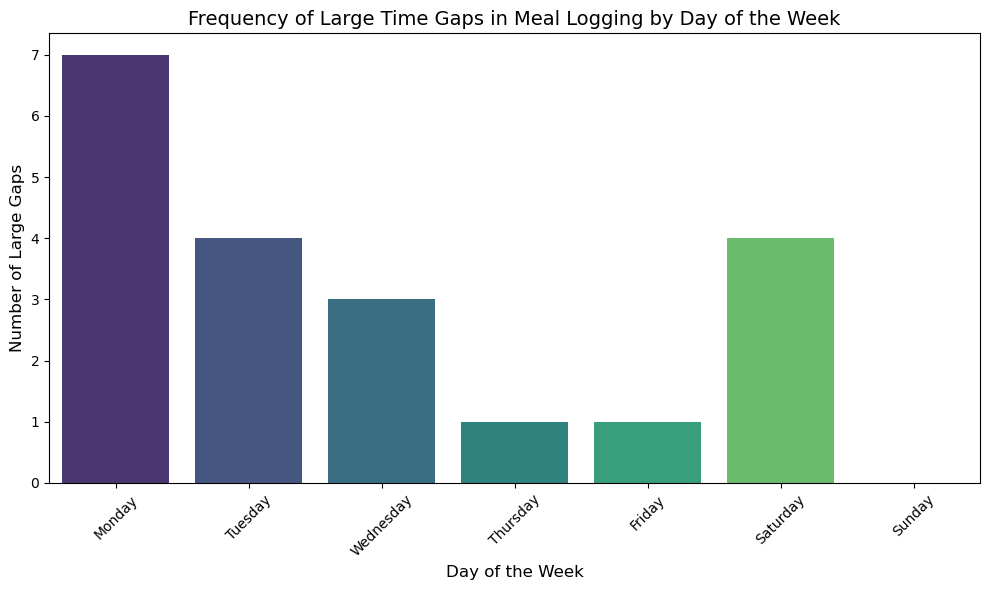

In [23]:
# Calculate the value counts for each day of the week
day_of_week_counts = df_large_gaps['day_of_week'].value_counts().reset_index()
day_of_week_counts.columns = ['day_of_week', 'count'] # Rename the columns

# Ensure the column 'day_of_week' is ordered correctly
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts['day_of_week'] = pd.Categorical(day_of_week_counts['day_of_week'], categories=order_of_days, ordered=True)
day_of_week_counts.sort_values('day_of_week', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='count', data=day_of_week_counts, palette='viridis')

plt.title('Frequency of Large Time Gaps in Meal Logging by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Large Gaps', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

We can see here that the end of the week is tendentially the moment where this user is more consistent in logging his/her food.\
The best approach here would be probably to tailor some messages for Monday to Wednesday.

#### Time Gaps by Hours

In [24]:
# Analyze time of the day
df_large_gaps.loc[:, 'hour_of_day'] = df_large_gaps['local_time'].dt.hour
hourly_distribution = df_large_gaps['hour_of_day'].value_counts().sort_index()
print(hourly_distribution)

hour_of_day
11    3
12    8
14    1
15    1
17    1
19    2
20    4
Name: count, dtype: int64


/var/folders/gb/6y2drydj77bb8qvwlk4l05m40000gn/T/ipykernel_80754/4181622822.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour_of_day', y='count', data=df_hourly_distribution, palette='coolwarm')


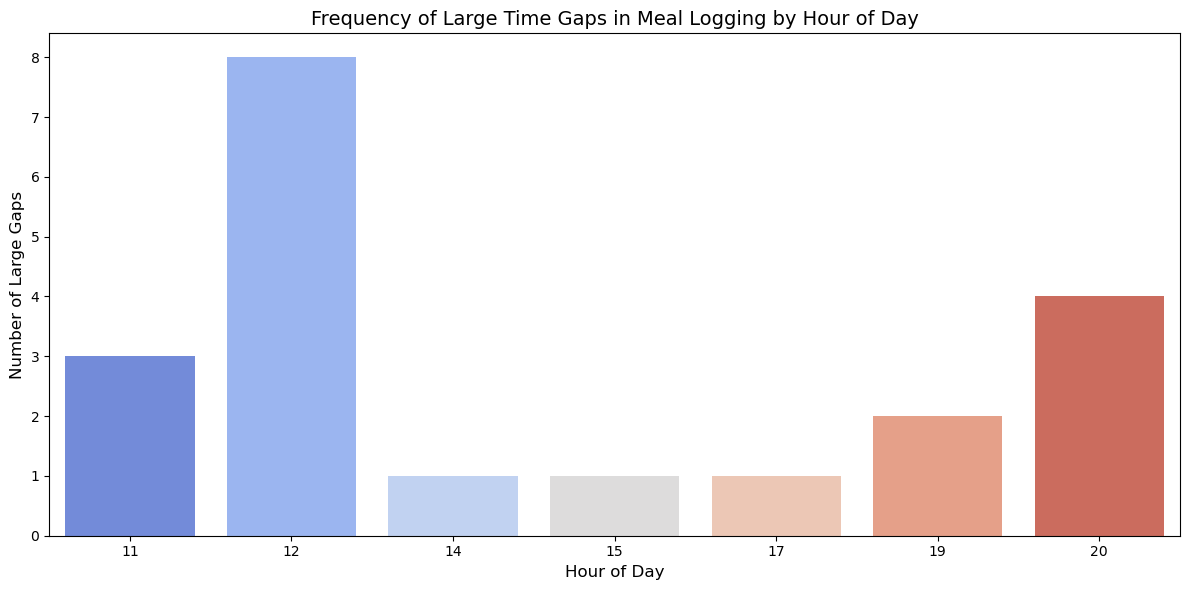

In [25]:
# Convert the hourly_distribution Series into a DataFrame
df_hourly_distribution = hourly_distribution.reset_index()
df_hourly_distribution.columns = ['hour_of_day', 'count'] # Rename the columns

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='count', data=df_hourly_distribution, palette='coolwarm')

plt.title('Frequency of Large Time Gaps in Meal Logging by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Large Gaps', fontsize=12)
plt.xticks(range(len(df_hourly_distribution['hour_of_day'])), labels=df_hourly_distribution['hour_of_day']) # Ensure all hours are displayed

plt.tight_layout()
plt.show()

A high frequency of large gaps in meal logging indicates times when users are less consistent with their tracking. By analyzing these patterns, we can better understand user behavior and devise strategies to encourage more regular logging, ultimately leading to more complete and accurate data collection.

#### Analyze Time Gaps by Day of the Week

In [26]:
df_most_meal_logs_grouped['day_of_week'] = df_most_meal_logs_grouped['local_time'].dt.day_name()
average_gap_by_day = df_most_meal_logs_grouped.groupby('day_of_week')['time_gap'].mean().sort_values()
print(average_gap_by_day)

day_of_week
Sunday         0 days 10:11:21.245500
Wednesday      0 days 15:37:36.763200
Thursday    0 days 16:44:12.920721722
Friday      0 days 17:31:16.063526400
Saturday       1 days 09:29:52.393000
Tuesday     1 days 22:36:19.302666666
Monday      1 days 23:32:08.367083333
Name: time_gap, dtype: timedelta64[ns]


#### Correlation analysis
No significant correlation exist. There is a slight tendency for the time gap to increase as the week progresses, but this relationship is very weak.

In [27]:
df_most_meal_logs_grouped['weekday_number'] = df_most_meal_logs_grouped['local_time'].dt.weekday

correlation = df_most_meal_logs_grouped[['weekday_number', 'time_gap']].corr()
print(correlation)

                weekday_number  time_gap
weekday_number         1.00000   0.08771
time_gap               0.08771   1.00000


#### Detecting Anomalies

In [28]:
# Ensure 'time_gap' is in the correct format (if it's not already)
df_most_meal_logs_grouped['time_gap'] = pd.to_datetime(df_most_meal_logs_grouped['local_time']).diff()

# Convert 'time_gap' from Timedelta to total seconds as a float
df_most_meal_logs_grouped['time_gap_seconds'] = df_most_meal_logs_grouped['time_gap'].dt.total_seconds().fillna(0)

from sklearn.ensemble import IsolationForest

# Fit the IsolationForest model
model = IsolationForest(n_estimators=100, contamination=0.1)
model.fit(df_most_meal_logs_grouped[['time_gap_seconds']])

# Predict anomalies
df_most_meal_logs_grouped['anomaly'] = model.predict(df_most_meal_logs_grouped[['time_gap_seconds']])

# Filter anomalies
anomalies = df_most_meal_logs_grouped[df_most_meal_logs_grouped['anomaly'] == -1]

anomalies.head(3)

/Users/andreaperozziello/opt/anaconda3/envs/myfoodrepo-env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,local_time,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,food_name,time_gap,day_of_week,weekday_number,time_gap_seconds,anomaly
8,2023-12-18 17:05:56.155000+01:00,0.16,500.00,0.02,0.02,0.00,0.00,0.0,"Drinking water (average Switzerland), nan",4 days 03:33:26.825000,Monday,0,358406.825,-1
18,2023-12-30 19:50:03.617000+01:00,1146.80,665.23,90.20,47.25,64.63,30.34,8.4,"Chicken, Vegetable au gratin, baked, Béchamel ...",2 days 04:16:27.408000,Saturday,5,188187.408,-1
19,2024-01-09 12:07:03.532000+01:00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,nan,9 days 16:16:59.915000,Tuesday,1,836219.915,-1


#### Conclusions

This time gap analysis allows us to identify patterns in which users, are inconsistent in their logging activity.\
The approach here is to take advantage of the days and hours in which we identified inconsistencies.

Finally, the recommended solution would be to send notification on the most forgetful days and hours. The reminder should be sent 15 minutes before the forgetful moment usually takes place.

For this specific user, given the available data the reminders should be sent on:
- **Monday** at 11am and 19pm
- **Tuesday** at 11am and 19pm 

### Calorie Anomalies Analysis
To analyze the Calorie Gap in the context of time gap analysis, we aim to understand how the energy (calories) intake varies over time and identify any patterns or anomalies in calorie consumption. This analysis could reveal insights into eating habits, such as periods of under-eating or overeating, and help in tailoring interventions for more balanced nutrition. Here’s how to approach it:

#### Data Preparation
Ensure correct data and Sort Data

In [29]:
df_most_meal_logs_grouped['local_time'] = pd.to_datetime(df_most_meal_logs_grouped['local_time'])
df_most_meal_logs_grouped['energy_kcal'] = pd.to_numeric(df_most_meal_logs_grouped['energy_kcal'], errors='coerce')

df_most_meal_logs_grouped.sort_values(by='local_time', inplace=True)

#### Daily Calorie Aggregation
Total calorie intake for each day

In [30]:
df_most_meal_logs_grouped['date'] = df_most_meal_logs_grouped['local_time'].dt.date
df_daily_calories = df_most_meal_logs_grouped.groupby('date')['energy_kcal'].sum().reset_index()
df_daily_calories['day_of_week'] = df_most_meal_logs_grouped['local_time'].dt.day_name()


print_df_shape(df_daily_calories)
df_daily_calories.head(3)

The dataframe has this shape: (52, 3)


,date,energy_kcal,day_of_week
0,2023-12-12,195.80,Tuesday
1,2023-12-13,1032.95,Wednesday
2,2023-12-14,2091.20,Wednesday


#### Identifying Baseline Patterns
Analyzing the aggregated daily calorie data to establish baseline patterns.

##### Descriptive Statistics
Statistical summary of daily calorie intake. This will provide insights into the central tendency, spread, and overall distribution of the data.

In [31]:
daily_calories_describe = df_daily_calories['energy_kcal'].describe()
print(daily_calories_describe)

count      52.000000
mean     1522.389423
std      1392.868039
min         0.000000
25%       490.800000
50%      1158.150000
75%      2105.290000
max      5736.740000
Name: energy_kcal, dtype: float64


##### Daily Calories Trend Analysis

###### Time Series Plot
Plotting daily calorie intake over time can visually reveal trends, cyclical patterns, or outliers.

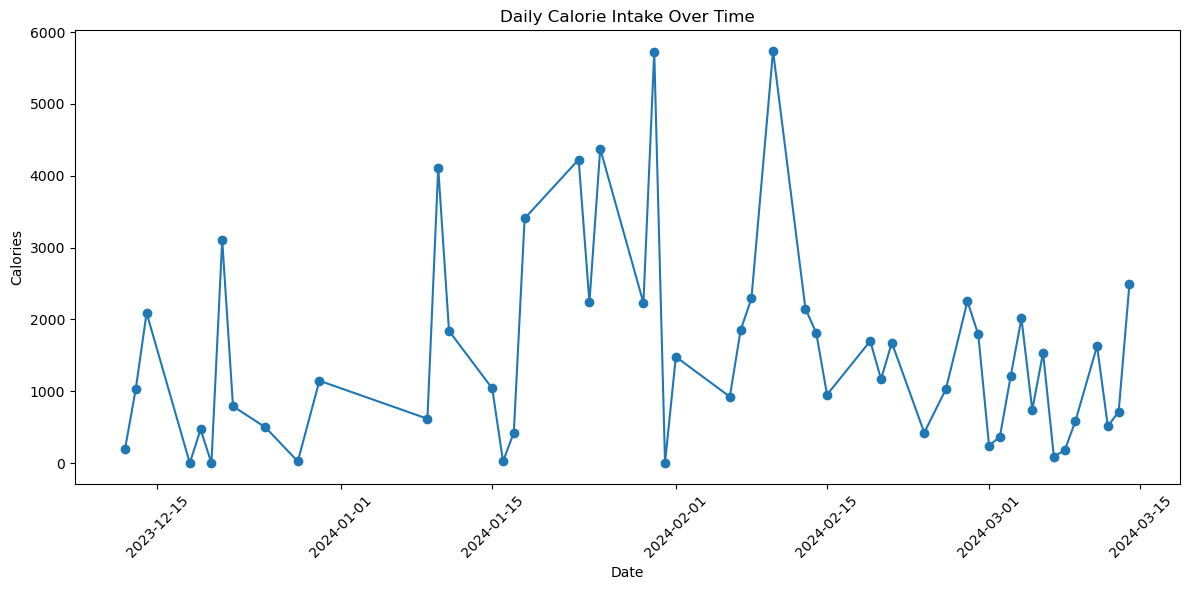

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df_daily_calories['date'], df_daily_calories['energy_kcal'], marker='o', linestyle='-')
plt.title('Daily Calorie Intake Over Time')
plt.xlabel('Date')
plt.ylabel('Calories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###### Rolling Mean
A rolling mean can help smooth out short-term fluctuations and highlight longer-term trends in calorie intake.

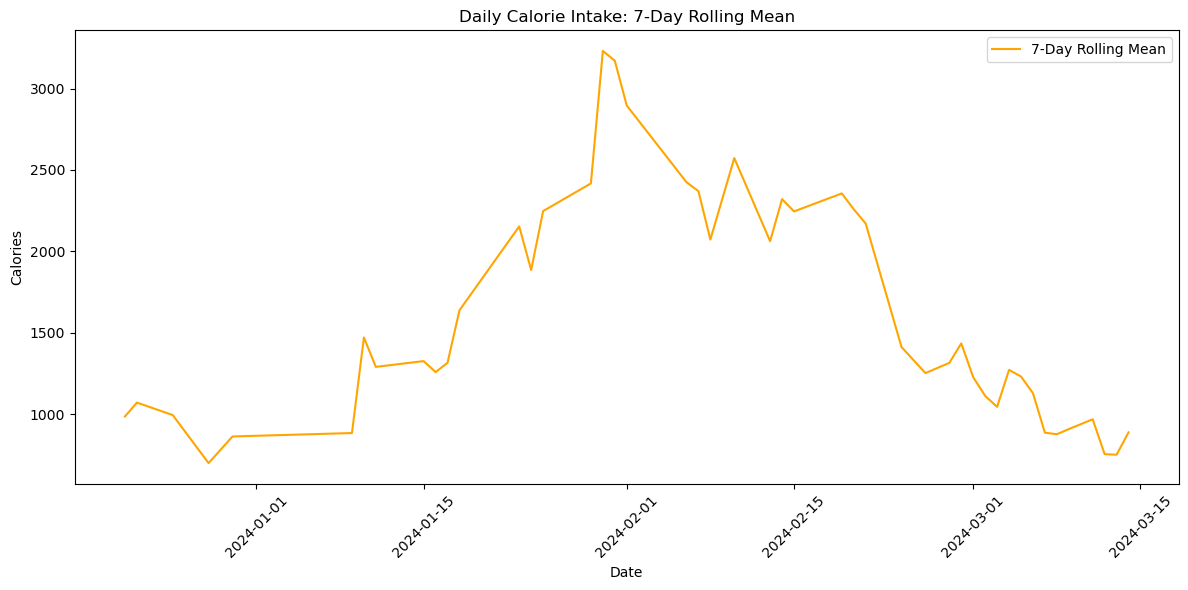

In [33]:
df_daily_calories['rolling_mean'] = df_daily_calories['energy_kcal'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_daily_calories['date'], df_daily_calories['rolling_mean'], color='orange', label='7-Day Rolling Mean')
plt.title('Daily Calorie Intake: 7-Day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Calories')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Anomaly Detection
Detecting anomalies in daily calorie intake is critical for identifying days with unusual eating patterns, which can be instrumental in understanding dietary habits and guiding nutritional interventions.

##### Statistical Method
Using a statistical method involves identifying days where calorie intake significantly deviates from established norms. This approach typically relies on calculating the mean and standard deviation of daily calorie intake and then finding instances that fall outside an acceptable range (e.g., more than 2 standard deviations from the mean).

In [34]:
mean_calories = df_daily_calories['energy_kcal'].mean()
std_calories = df_daily_calories['energy_kcal'].std()

# Define thresholds
lower_threshold = mean_calories - (2 * std_calories)
upper_threshold = mean_calories + (2 * std_calories) #TODO upper threshold is too high

# Find anomalies
df_daily_anomalies = df_daily_calories[(df_daily_calories['energy_kcal'] < lower_threshold) | (df_daily_calories['energy_kcal'] > upper_threshold)]

print_df_shape(df_daily_anomalies)
df_daily_anomalies.head(3)

The dataframe has this shape: (3, 4)


,date,energy_kcal,day_of_week,rolling_mean
20,2024-01-25,4374.69,Tuesday,2247.197143
22,2024-01-30,5723.38,Thursday,3231.462857
28,2024-02-10,5736.74,Thursday,2573.010000


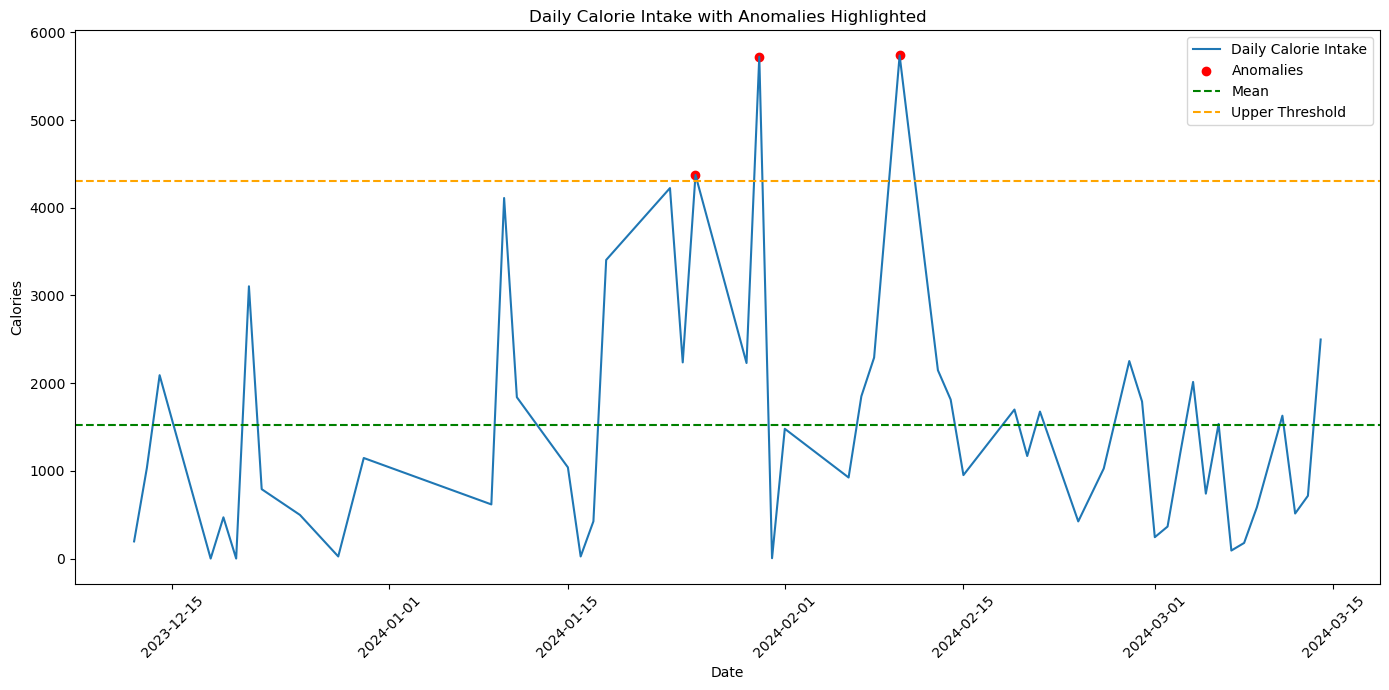

In [35]:
# Plot daily calorie intake
plt.figure(figsize=(14, 7))
plt.plot(df_daily_calories['date'], df_daily_calories['energy_kcal'], label='Daily Calorie Intake')

# Highlight anomalies
plt.scatter(df_daily_anomalies['date'], df_daily_anomalies['energy_kcal'], color='red', label='Anomalies')

# Add mean and threshold lines
plt.axhline(mean_calories, color='green', linestyle='--', label='Mean')
plt.axhline(upper_threshold, color='orange', linestyle='--', label='Upper Threshold')

plt.xlabel('Date')
plt.ylabel('Calories')
plt.title('Daily Calorie Intake with Anomalies Highlighted')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### Machine Learning Model: Isolation Forest
This model is particularly effective for identifying outliers in datasets without requiring a predefined notion of what constitutes an anomaly.

In [36]:
model = IsolationForest(n_estimators=100, contamination='auto')
df_daily_calories['anomaly'] = model.fit_predict(df_daily_calories[['energy_kcal']])

df_daily_anomalies = df_daily_calories[df_daily_calories['anomaly'] == -1]

df_daily_anomalies.head(8)


,date,energy_kcal,day_of_week,rolling_mean,anomaly
3,2023-12-18,0.16,Wednesday,NaN,-1
5,2023-12-20,0.00,Thursday,NaN,-1
6,2023-12-21,3104.88,Thursday,985.055714,-1
9,2023-12-28,24.00,Tuesday,698.335714,-1
12,2024-01-10,4111.60,Friday,1470.538571,-1
15,2024-01-16,24.00,Monday,1257.625714,-1
17,2024-01-18,3405.20,Thursday,1637.530000,-1
18,2024-01-23,4224.98,Saturday,2152.872857,-1


#### Time of Day Analysis
Break down of calories intake by time of day within each day.

In [37]:
# Define bins for the hours of the day, noting that the end of one bin is the start of the next
bins = [0, 5, 9, 11, 14, 17, 22, 24]

# Define labels for each bin
labels = ['Night Snack', 'Breakfast', 'Morning Snack', 'Lunch', 'Afternoon Snack', 'Dinner', 'Night Snack']

# Cut the hour from the 'local_time' datetime into bins and assign labels
df_most_meal_logs_grouped['meal_category'] = pd.cut(df_most_meal_logs_grouped['local_time'].dt.hour, bins=bins, labels=labels, right=False, ordered=False)

# Since our 'Night Snack' category spans across two bins, we'll need to adjust the last 'Night Snack' entries manually
# This step ensures that hours between 0 and 5 are labeled correctly as 'Night Snack'
df_most_meal_logs_grouped.loc[df_most_meal_logs_grouped['local_time'].dt.hour < 5, 'meal_category'] = 'Night Snack'

print_df_shape(df_most_meal_logs_grouped)
df_most_meal_logs_grouped.head(5)


The dataframe has this shape: (80, 16)


,local_time,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,food_name,time_gap,day_of_week,weekday_number,time_gap_seconds,anomaly,date,meal_category
0,2023-12-12 17:10:27.257000+01:00,195.80,166.76,2.42,43.34,0.22,0.00,5.94,"Banana, raw",NaT,Tuesday,1,0.000,1,2023-12-12,Dinner
1,2023-12-13 09:03:22.290000+01:00,2.00,99.60,0.10,0.30,0.00,0.00,0.10,"Coffee, black, no sugar added",0 days 15:52:55.033000,Wednesday,2,57175.033,1,2023-12-13,Morning Snack
2,2023-12-13 10:06:45.225000+01:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0 days 01:03:22.935000,Wednesday,2,3802.935,1,2023-12-13,Morning Snack
3,2023-12-13 12:03:59.411000+01:00,522.15,575.86,21.13,71.96,15.80,6.27,6.35,"Carrot, steamed, without addition of salt, Ric...",0 days 01:57:14.186000,Wednesday,2,7034.186,1,2023-12-13,Lunch
4,2023-12-13 19:27:04.751000+01:00,508.80,130.42,13.94,66.28,19.72,2.64,4.80,"Molluscs, blue mussel, raw, Oil, olive, Pasta ...",0 days 07:23:05.340000,Wednesday,2,26585.340,1,2023-12-13,Dinner


In [38]:
average_calories_per_meal = df_most_meal_logs_grouped.groupby('meal_category')['energy_kcal'].mean().reset_index()

print(average_calories_per_meal)

     meal_category  energy_kcal
0  Afternoon Snack   288.941667
1        Breakfast    24.000000
2           Dinner   859.893333
3            Lunch  1302.836279
4    Morning Snack   119.300000
5      Night Snack   129.766667


In [39]:
df_morning_snack = df_most_meal_logs_grouped[df_most_meal_logs_grouped['meal_category'] == 'Morning Snack']
df_breakfast = df_most_meal_logs_grouped[df_most_meal_logs_grouped['meal_category'] == 'Breakfast']
df_breakfast.head(10)

,local_time,energy_kcal,water,protein,carbohydrates,fat,fatty_acids_saturated,fiber,food_name,time_gap,day_of_week,weekday_number,time_gap_seconds,anomaly,date,meal_category
26,2024-01-16 08:57:13.244000+01:00,24.0,294.0,0.1,5.7,0.0,0.0,0.1,"Coffee, black, no sugar added, Tea, apple",0 days 15:54:56.622000,Tuesday,1,57296.622,1,2024-01-16,Breakfast


#### Visualization

##### Daily Calorie Intake with Anomalies Highlighted

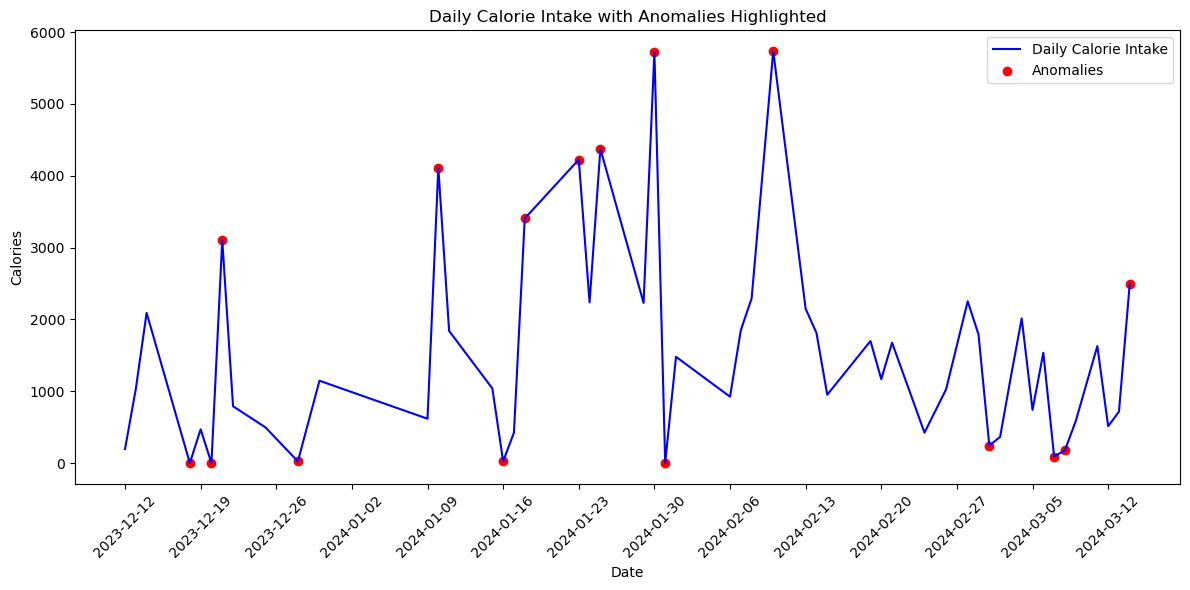

In [40]:
# Assuming `daily_calories` DataFrame with a 'date' column and 'energy_kcal' for total daily intake
# And 'anomaly' column where -1 indicates anomalies
fig, ax = plt.subplots(figsize=(12, 6))

# Plot daily calorie intake
ax.plot(df_daily_calories['date'], df_daily_calories['energy_kcal'], label='Daily Calorie Intake', linestyle='-', marker='', color='blue')

# Highlight anomalies
# anomalies = df_daily_calories[df_daily_calories['anomaly'] == -1]
ax.scatter(df_daily_anomalies['date'], df_daily_anomalies['energy_kcal'], color='red', label='Anomalies')

# Improve formatting
ax.set_title('Daily Calorie Intake with Anomalies Highlighted')
ax.set_xlabel('Date')
ax.set_ylabel('Calories')
ax.legend()
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Calorie Intake by Time of Day


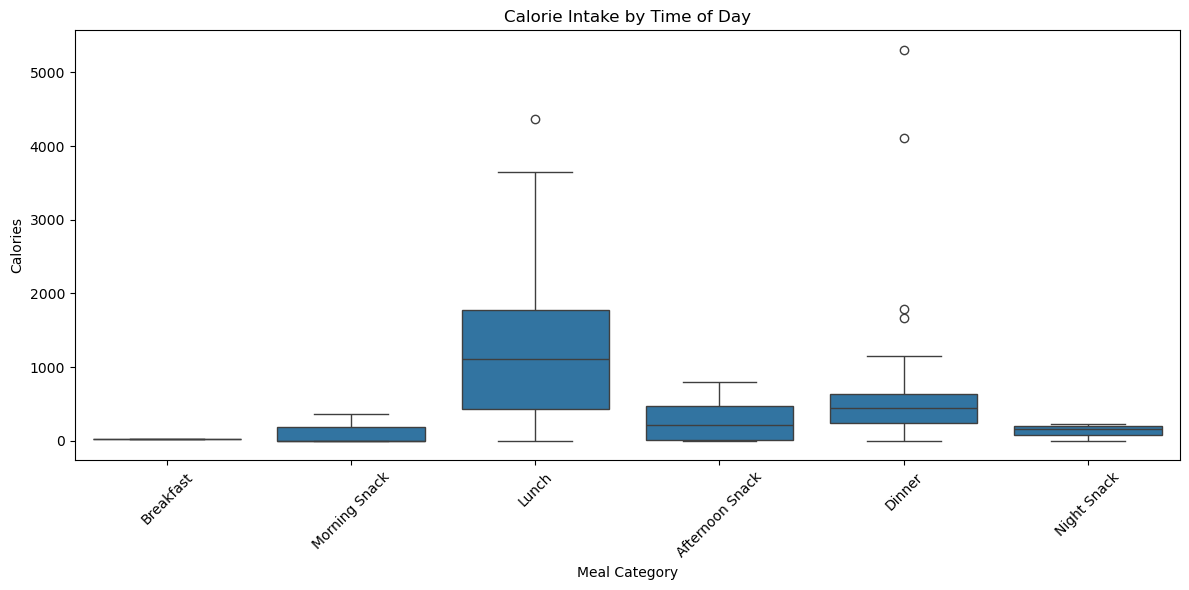

In [41]:
# Assuming `df` has 'meal_category' and 'energy_kcal' for each entry
fig, ax = plt.subplots(figsize=(12, 6))

# Create a box plot
sns.boxplot(x='meal_category', y='energy_kcal', data=df_most_meal_logs_grouped, order=['Breakfast', 'Morning Snack', 'Lunch', 'Afternoon Snack', 'Dinner', 'Night Snack'])

# Improve formatting
ax.set_title('Calorie Intake by Time of Day')
ax.set_xlabel('Meal Category')
ax.set_ylabel('Calories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Interpretation and Action

##### Pattern Recognition in Anomalies

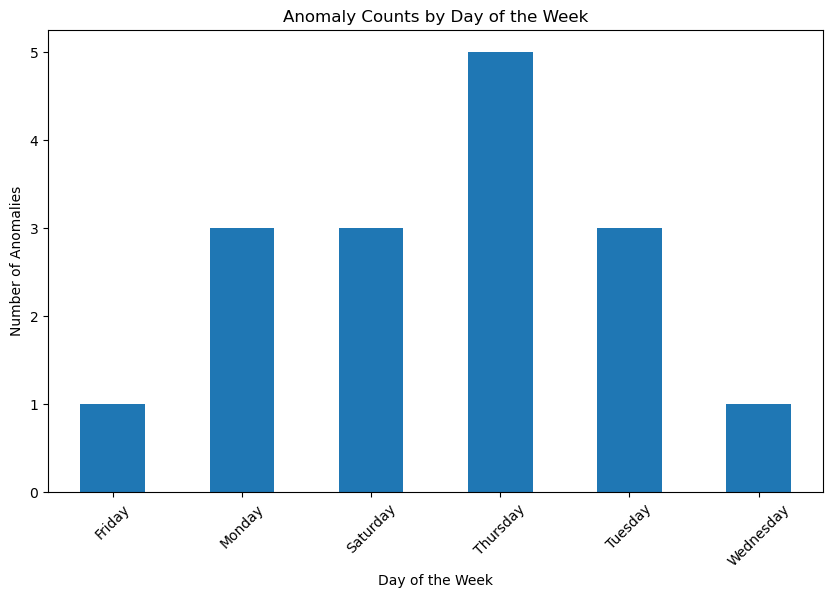

In [42]:
# Aggregate anomalies by day of the week
anomaly_counts_by_day = df_daily_anomalies['day_of_week'].value_counts().sort_index()

# Plot
anomaly_counts_by_day.plot(kind='bar', figsize=(10, 6), title='Anomaly Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.show()


##### Analyzing Contextual Factors

In [43]:
import numpy as np

# Mark weekends in the daily_calories DataFrame
df_daily_calories['is_weekend'] = df_daily_calories['date'].dt.dayofweek.isin([5, 6])

# Assuming you have a list of holiday dates
holidays = ['2023-12-25', '2024-01-01']  # Example holidays
df_daily_calories['is_holiday'] = df_daily_calories['date'].isin(holidays)

# Visualization
plt.figure(figsize=(14, 7))
plt.scatter(df_daily_calories['date'], df_daily_calories['energy_kcal'], 
            c=np.where(df_daily_calories['is_weekend'], 'blue', np.where(df_daily_calories['is_holiday'], 'red', 'grey')), 
            label='Daily Calorie Intake')

# Customize for clarity
plt.title('Daily Calorie Intake with Weekends and Holidays Highlighted')
plt.xlabel('Date')
plt.ylabel('Calories')
plt.legend(['Weekend', 'Holiday', 'Weekday'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values